# Pancancer event summaries 

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(ggsci)
library(ggpubr)
library(ggtext)
library(ggnewscale)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Load data

In [2]:
events_used<-c("SE","A3","A5","MX","RI","AF","AL")

In [3]:
res.stats<-readRDS("../input/tcga.condition.res.lfcShrink.stats.RDS") %>%
            filter(event_type%in%events_used) %>%
            mutate(exp_var=case_when(exp_var=="conditiontumor" ~ "tumor",
                                     exp_var=="sex1" ~ "sex_cm",
                                     exp_var=="impurity" ~ "impurity_cm", 
                                     exp_var=="age" ~ "age_cm",
                                     TRUE ~ exp_var))
stg.res.stats<-readRDS("../input/tcga.tumorStageContinuous.res.lfcShrink.stats.RDS") %>%
             filter(event_type%in%events_used) %>%
             mutate(exp_var=case_when(exp_var=="conditiontumor" ~ "tumor",
                                     exp_var=="sex1" ~ "sex_sm",
                                     exp_var=="impurity" ~ "impurity_sm", 
                                     exp_var=="age" ~ "age_sm",
                                     TRUE ~ exp_var))

##  Visualize results

In [4]:
res<-rbind(res.stats,stg.res.stats)
totals<-res %>%
        filter(exp_var%in%c("stage","tumor")) %>%
        group_by(cancer,event_type,exp_var) %>%
        summarize(n=sum(total_events),.groups="drop") %>%
        select(-cancer) %>% 
        group_by(event_type) %>% 
        slice_max(n,n=1) %>%       
        arrange(desc(n))

In [5]:
res <- res %>%
           mutate(event_type=factor(event_type,levels=totals$event_type)) %>%
           mutate(exp_var=factor(exp_var,levels = c("tumor","impurity_cm","sex_cm","age_cm","stage","impurity_sm","sex_sm","age_sm")))%>%
           mutate(cancer=factor(cancer,levels=c("SKCM","SARC","LAML","TGCT","UCEC","CESC","PRAD",
                                                "READ","BLCA","COAD","PAAD","CHOL",
                                                "KIRP","KIRC","KICH","ACC","PCPG","STAD",
                                                "LIHC","MESO","LUSC","LUAD","BRCA","THCA",
                                                "ESCA","HNSC"))) %>% 
          mutate(p_sig_events = round((sig_events/total_events),6)) %>%
          mutate(log_p_sig_events=ifelse(p_sig_events==0,0,log(p_sig_events)))

all<-res %>%
     ungroup() %>%
     distinct(exp_var,cancer,event_type) %>%
     tidyr::expand(exp_var,cancer,event_type) 
res<-res %>% 
     ungroup() %>%
     dplyr::right_join(all) %>%
     select(-analysis) %>%
     mutate(model=ifelse(exp_var %in% c('tumor','impurity_cm','sex_cm','age_cm'),'condition','stage'),
            exp_var=factor(ifelse(exp_var %in% c('tumor','stage'),"VOI",sub("_.*","",exp_var)),levels=c('VOI','impurity','sex','age')))

mp<-as.numeric(round(quantile(res$p_sig_events,0.74,na.rm=TRUE),6))
up<-as.numeric(round(quantile(res$p_sig_events,0.98,na.rm=TRUE),6))
lims<-c(0,up)

res <- res %>%
       mutate(p_sig_events_viz=case_when(p_sig_events>up ~ up,
                                         TRUE ~ p_sig_events))  

Joining, by = c("cancer", "event_type", "exp_var")


### Visualize stats

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


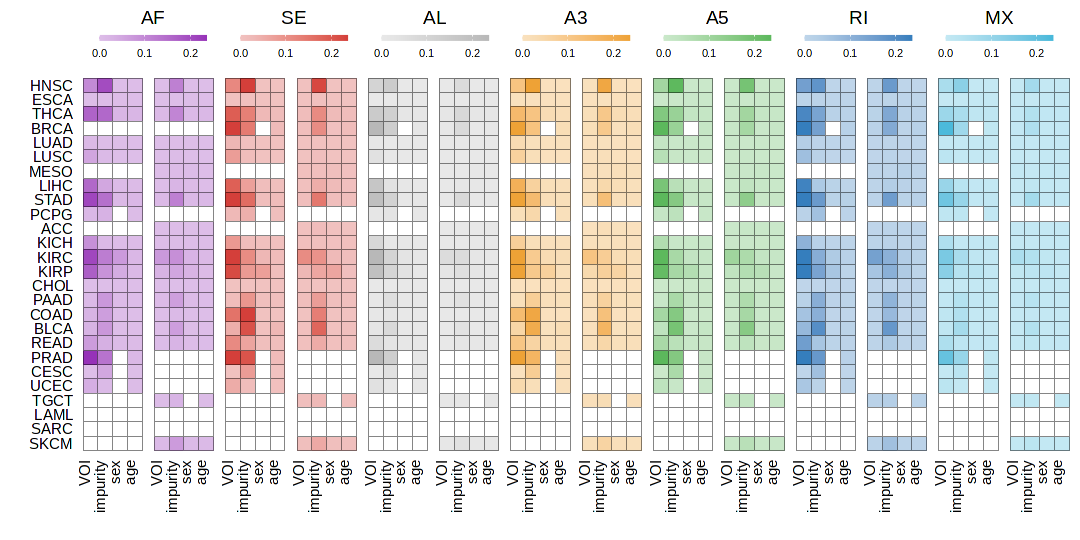

In [6]:
options(repr.plot.width=9,repr.plot.height=4.5)
p<-ggplot(data=res,aes(x=exp_var,y=cancer))+
      facet_grid(~event_type+model,)+
      theme(legend.position = "top",
            panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.ticks = element_blank(),
            text = element_text(family = "arial"),
            axis.text.x = element_text(angle=90,vjust=0,hjust=1,color="black"),
            axis.text.y = element_text(color="black"),
            axis.line = element_blank(),
            legend.key.height= unit(0.25, 'cm'),
            legend.key.width= unit(0.15, 'cm'),
            legend.spacing.x = unit(0.7, 'cm'),
            legend.margin=margin(t = 0, unit='cm'),
            legend.text = element_text(size=6),
            strip.background = element_blank(),
            strip.text.x = element_blank(),
            panel.spacing.y = unit(0.1, "cm"))+
      labs(y="",x="")

ev.colors<-pal_locuszoom()(7)
names(ev.colors)<-events_used
plots_list<-list()
i<-1
for(event in totals$event_type){

    plot.data<-res %>% 
               filter(event_type==event)
    
    colfunc <- colorRampPalette(c('#FFFFFF',ev.colors[event]))
    cols<-colfunc(9)
    
    p <- p +
         geom_tile(data=plot.data,aes(fill=p_sig_events_viz),color="black",size=0.1,inherit.aes = TRUE) +
         scale_fill_gradient2(low = '#FFFFFF',
                             mid = cols[4],
                             high = ev.colors[event],
                             limits= lims,
                             midpoint= mp,
                             breaks = c(0,0.1,0.2),
                             guide = guide_colourbar(direction = "horizontal", 
                                                     barheight = 0.25,
                                                     barwidth = 4.5,
                                                     title.position = "top",
                                                     title.hjust = 0.5,
                                                     order = i,
                                                     label.position = "bottom"),
                             na.value="white") +
         labs(fill=event)+
         new_scale_fill()
    i<-i+1
}
p

In [7]:
legend<-get_legend(p)%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/event_stats/legend.barcodes.all.events.lfcShrink.pdf",width = 4.5,height=9,units="in",device=cairo_pdf)
ggsave(plot=p,filename="../output/figures/event_stats/barcodes.all.events.lfcShrink.pdf",width = 9,height = 4.5,units="in",device = cairo_pdf)

# Extra

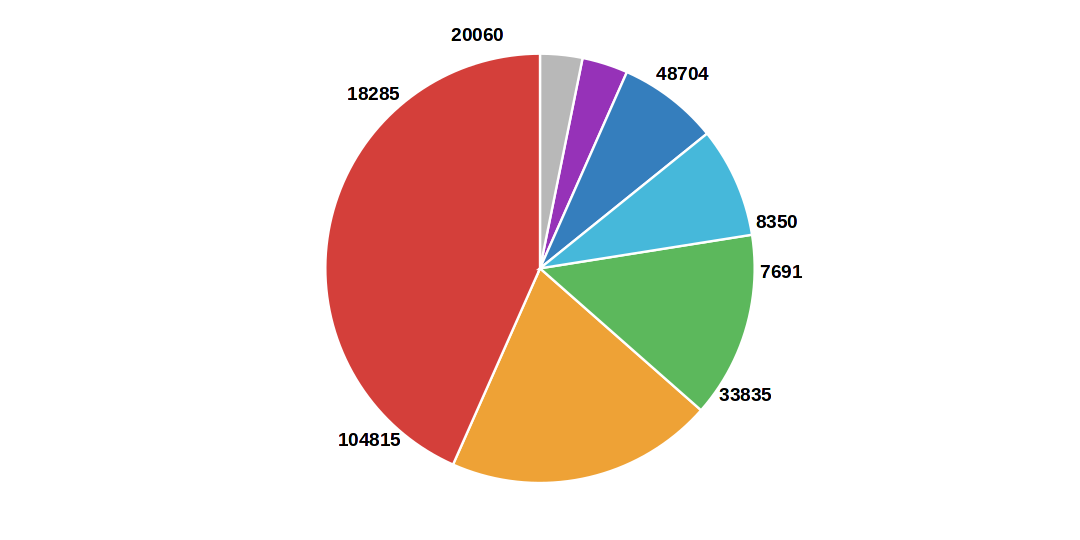

In [8]:
data <- totals %>% 
  arrange(desc(event_type)) %>%
  mutate(prop = n / sum(totals$n) *100) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop,
        lab = paste0(n),
        event_type=factor(event_type,levels = totals$event_type))

p<-data %>%
    ggplot(.,aes(x=1,y=prop,fill=event_type))+
      geom_bar(stat="identity", width=1, color="white") +
      coord_polar("y", start=0,) +
      scale_fill_locuszoom()+
      theme_void()+
      theme(axis.text.x = element_text(color="black",vjust = 20,face="bold"),
            legend.position="none")+
      scale_y_continuous(breaks=cumsum(data$prop) - data$prop / 2, labels = data$lab)
p